# **Home Credit Default Risk**


<h1> FDS - A.Y. 2019/2020</h1> </br>
<h2>Students:</h2>

*   Taiello Riccardo (1914000)

</br>
<h2>Professors:</h2>

*  Bressan Marco
* Galasso Fabio

# Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **Dataset path**

In [ ]:
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive/Colab Notebooks"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/FDS/home-credit-default"

In [ ]:
PATH_DATASET = GDRIVE_DATA_DIR+"/dataset/raw"
PATH_PREPROCESSED = GDRIVE_DATA_DIR+"/dataset/processed"
PATH_PICKLE = GDRIVE_DATA_DIR+"/pickle"
PATH_SUBMISSION = GDRIVE_DATA_DIR+"/submission"

In [ ]:
SEED = 42

# **Python import**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import gc
from sklearn.metrics import roc_auc_score


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import time
from contextlib import contextmanager

#**1. Preprocessing**

In [ ]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [ ]:
#@title 1.1. Convert Types
def convert_types(df, to_categorize = False, print_info = True):
    '''Shrink down as much as we can the size of the dataframes.'''
    import pandas as pd
    import numpy as np
    original_memory = df.memory_usage().sum()

    # Convert the nan values into the standard way
    df.replace(['nan'], np.nan,inplace = True)
    # ids to integers
    id_feature = [col for col in df if 'SK_ID' in col]
    if id_feature:
     df.loc[:,id_feature] = df[id_feature].fillna(0).astype(np.int32)

    # Objects to category
    category_features = [col for col in df if df[col].dtype == 'object']
    if category_features:
      if to_categorize:
        df.loc[:,category_features] = df[category_features].apply(lambda col : pd.Categorical(col).codes)
        
        df.loc[:,category_features] = df[category_features].replace({-1:np.nan}) # Fix pd.Categorical(col) which returns -1 as NaN value
      
      df.loc[:,category_features] = df[category_features].astype('category')
    # Float64 to float32
    float_features = [col for col in df if df[col].dtype == float ]
    if float_features:
      df.loc[:,float_features] = df[float_features].astype(np.float32)    

    # Int64 to int32
    integer_features = [col for col in df if df[col].dtype == int ]
    if integer_features:
      df.loc[:,integer_features] = df[integer_features].astype(np.int32)

    # Boolean 
    '''
    binary_features = [col for col in df if df[col].nunique() == 2 ]
    if binary_features:
      df[binary_features] = df[binary_features].astype(np.int32) # IMPORTANT TO DEAL WITH NaN VALUES (don't use bool)
      print(df.CODE_GENDER.value_counts())
    '''

    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [ ]:
#@title 1.2. Label Encoder
def label_encoder(df):
  '''Map the cateogory features into integer values'''
    from sklearn.preprocessing import LabelEncoder
    # get the columns
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(include=['category']).columns.to_list()
    for c in categorical_columns:
        LE = LabelEncoder()
        df[c] = LE.fit_transform(list(df[c].values.astype('str')))
    # df = pd.get_dummies(df, columns= categorical_columns, dummy_na= False)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [ ]:
#@title 1.3. Clean Null Value
def clean_null_value(df,percent=60):
    mean_null = df.isnull().mean() * 100
    col_removed = mean_null[mean_null >= percent].index.tolist()
    return col_removed

# **2. Load Dataset**

In [ ]:
#@title 2.1. Load Application
def load_application(df):
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    df = convert_types(df, to_categorize=False, print_info=True)

    # Categorical features with One-Hot encode
    df, cat_cols = label_encoder(df)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    return df

In [ ]:
#@title 2.2. Load Bureau & Balance
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(PATH_DATASET+'/bureau.csv', nrows = num_rows)
    # bureau = clean_null_value(bureau) 
    bureau = convert_types(bureau, to_categorize=False,print_info=True)
    bb = pd.read_csv(PATH_DATASET+'/bureau_balance.csv',nrows = num_rows)
    # bb = clean_null_value(bb) 
    bb = convert_types(bb,  to_categorize=False, print_info=True)
    bb, bb_cat = label_encoder(bb)
    bureau, bureau_cat = label_encoder(bureau)
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['var', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['var', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'var'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'var'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'var'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'var']
    }
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + col[0] + "_" + col[1].upper() for col in bureau_agg.columns.tolist()])

    del bureau
    gc.collect()
    return bureau_agg

In [ ]:
#@title 2.3. Load Previous Application
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(PATH_DATASET+'/previous_application.csv', nrows = num_rows)
    # prev = clean_null_value(prev) 
    prev = convert_types(prev, to_categorize=False,print_info=True)
    prev, cat_cols = label_encoder(prev)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'var'],
    }
    # Previous applications categorical features
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + col[0] + "_" + col[1].upper() for col in prev_agg.columns.tolist()])

    del prev
    gc.collect()
    return prev_agg

In [ ]:
#@title 2.4. Load PosCash Balance
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(PATH_DATASET+'/POS_CASH_balance.csv', nrows = num_rows)
    # pos = clean_null_value(pos) 
    pos = convert_types(pos, to_categorize=False,print_info=True)
    pos, cat_cols = label_encoder(pos)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean','var'],
        'SK_DPD_DEF': ['max', 'mean','var']
    }    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    


In [ ]:
#@title 2.5. Load Installments Payments
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(PATH_DATASET+'/installments_payments.csv', nrows = num_rows)
   # ins = clean_null_value(ins) 
    ins = convert_types(ins, to_categorize=False,print_info=True)
    ins, cat_cols = label_encoder(ins)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'var'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + col[0] + "_" + col[1].upper() for col in ins_agg.columns.tolist()])

    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()        
    return ins_agg

In [ ]:
#@title 2.5. Load Credit Card Balance
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(PATH_DATASET+'/credit_card_balance.csv', nrows = num_rows)
    # cc = clean_null_value(cc) 
    cc = convert_types(cc, to_categorize=False,print_info=True)
    cc, cat_cols = label_encoder(cc)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [ ]:
def join_all_df(df):
    num_rows = None
    with timer("Load Application"):
        df = load_application(df)
        print("Train & test shape ", df.shape)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

# **3. Create & Join Dataset**

In [ ]:
SPEED = True

In [ ]:
#@title Load Train and Test from .csv 
application_train = pd.read_csv(PATH_DATASET+"/application_train.csv")
application_test = pd.read_csv(PATH_DATASET+"/application_test.csv")

In [ ]:
#@title Merge *application* with the remains dataset
if SPEED:
  df = pd.read_csv(PATH_PREPROCESSED+"/merged_test.csv")
  # X_train_mice = pd.read_csv(PATH_PREPROCESSED+"/imputed/mice/mice_imputed.csv")
  #SELECTED_FEATURES = list(df.drop(columns=['TARGET']).columns)
  # df.loc[:,SELECTED_FEATURES] = X_train_mice
else:
  df = application_train.append(application_test).reset_index() 
  df = join_all_df(df)

In [ ]:
#@title 3.1. Split the merged dataset into Train and Test
train_df, test_df = df.iloc[:len(application_train)], df.iloc[len(application_train):]
train_df, test_df = convert_types(train_df), convert_types(test_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Original Memory Usage: 0.8 gb.
New Memory Usage: 0.4 gb.
Original Memory Usage: 0.13 gb.
New Memory Usage: 0.06 gb.


In [ ]:
print("The shape of the train dataset is:",train_df.shape)
print("The shape of the test dataset is:",test_df.shape)

The shape of the train dataset is: (307511, 326)
The shape of the test dataset is: (48744, 326)


In [ ]:
#train_df.loc[train_df.PAYMENT_RATE < 0.031037, 'PAYMENT_RATE'	] = 0.031037

In [ ]:
#@title 3.2. Extract features lists
def get_features_lists(df, target_variable = "TARGET", numerical = True, categorical = True, binary = True):
  # Take categorical features
  CATEGORICAL_FEATURES =  set(df.select_dtypes(include=['category']).columns.to_list())
  
  # Take binary features
  BINARY_FEATURES = [col for col in df if df[col].nunique() == 2 ]
  
  # include=['category'] also include binary feature, we subtract the intersection between the two feature list
  CATEGORICAL_FEATURES -= set(BINARY_FEATURES) 
  CATEGORICAL_FEATURES = list(CATEGORICAL_FEATURES)

  if target_variable is not None:  
    BINARY_FEATURES.remove('TARGET')
  
  # Take float features
  FLOAT_FEATURES = df.select_dtypes(include=['float32','float64']).columns.to_list()
  
  # Take integer features. Binary are int, we exclude all binary features
  INTEGER_FEATURES = [col for col in df if df[col].nunique() > 2 and (df[col].dtype == 'int32'or df[col].dtype == 'int64')] 
  

  return CATEGORICAL_FEATURES, FLOAT_FEATURES, BINARY_FEATURES, INTEGER_FEATURES

In [ ]:
CATEGORICAL_FEATURES, FLOAT_FEATURES, BINARY_FEATURES, INTEGER_FEATURES = get_features_lists(train_df)

In [ ]:
# Split train dataset in order to isolate the taget variable
X_train = train_df.drop(columns=["TARGET"])
y_train = train_df.TARGET

# **4. Missing Data Imputation**

In [ ]:
USE_PICKLE = True

In [ ]:
def imputation(df, imputer , filename_imputer :str, use_pickle=True):
    import pickle
    df = df.replace([np.inf, -np.inf], np.nan)
    imp_pickle_filename = PATH_PICKLE+filename_imputer
    if use_pickle is False:
      imputer.fit(df)
      with open(imp_pickle_filename, "wb") as imp_pickle:
        pickle.dump(imputer, imp_pickle)
    else:
      with open(imp_pickle_filename, "rb") as imp_pickle:
        imputer = pickle.load(imp_pickle)
    df.iloc[:,:] = imputer.transform(df)
    return df, imputer

In [ ]:
X_train_mice = X_train.copy(deep=True)

In [ ]:
#@title 4.1. MICE Data Missing Imputation
def mice_imputation(df, features: list, strategy: str = 'mean', use_pickle:bool= True):
  from sklearn.experimental import enable_iterative_imputer
  from sklearn.impute import IterativeImputer
  from sklearn.neighbors import KNeighborsRegressor

  mice_imp_pickle_filename = "/mice_imputer_fit.pkl"
  estimator = KNeighborsRegressor(n_neighbors=15,n_jobs=-1)
  mice_imputer = IterativeImputer(max_iter=5, random_state=SEED, initial_strategy=strategy,verbose = 2,skip_complete= True,estimator=estimator)
  df[features], mice_imputer = imputation(df[features], mice_imputer , filename_imputer = mice_imp_pickle_filename,use_pickle=use_pickle)
  return df, mice_imputer

In [ ]:
SELECTED_FEATURES = X_train.columns.to_list()
X_train_mice.loc[:,SELECTED_FEATURES], mice_imp_transformer = mice_imputation(X_train_mice.loc[:,SELECTED_FEATURES], features=SELECTED_FEATURES, use_pickle=USE_PICKLE)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator IterativeImputer from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


[IterativeImputer] Completing matrix with shape (307511, 325)
[IterativeImputer] Ending imputation round 1/2, elapsed time 2760.48


In [ ]:
test_df.loc[:,SELECTED_FEATURES] = mice_imp_transformer.transform(test_df[SELECTED_FEATURES])

[IterativeImputer] Completing matrix with shape (61502, 316)
[IterativeImputer] Ending imputation round 1/2, elapsed time 215.46
[IterativeImputer] Ending imputation round 2/2, elapsed time 397.32


In [ ]:
def clean_imputation(df) -> None:
    # modify in place, return no needed
    
    df[BINARY_FEATURES] = df[BINARY_FEATURES].round().astype(np.bool)
    df[INTEGER_FEATURES] = df[INTEGER_FEATURES].round().astype(np.int32)
    df[CATEGORICAL_FEATURES] = df[CATEGORICAL_FEATURES].round().astype(np.int32)

In [ ]:
CATEGORICAL_FEATURES, FLOAT_FEATURES, BINARY_FEATURES, INTEGER_FEATURES = get_features_lists(train_df[list(X_train.columns)],target_variable=None)
clean_imputation(X_train_mice.loc[:,list(X_train.columns)])

In [ ]:
X_train_mice = convert_types(X_train_mice)

Original Memory Usage: 0.93 gb.
New Memory Usage: 0.46 gb.


In [ ]:
train_df = convert_types(train_df)

# **5. Feature engineering**

In [ ]:
#@title Log Transformation
def log_transformation(feature):
  from sklearn.preprocessing import PowerTransformer

  log_trasformer = PowerTransformer() # log transformation
  target_feature = feature.to_numpy().reshape(-1,1)


  log_trasformer.fit(target_feature)
  log_scaled_feature = log_trasformer.transform(target_feature)
  return log_scaled_feature,log_trasformer

In [ ]:
#@title Standard Scaler Transformation
def std_transformation(feature):
  from sklearn.preprocessing import StandardScaler

  std_trasformer = StandardScaler() # std transformation
  target_feature = feature.to_numpy().reshape(-1,1)


  std_trasformer.fit(target_feature)
  std_scaled_feature = std_trasformer.transform(target_feature)
  return std_scaled_feature,std_trasformer

## **5.1. Data Visualization**

In [ ]:
def ecdf(data):
    import numpy as np
    # Empirical Cumulative Distribution Function
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

In [ ]:
def plot_feature(feature, label_ax):
  x_amt_credit, y_amt_credit = ecdf(feature)

  # Generate plot
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
  fig.suptitle('ECDF vs histogram:'+label_ax)
  ax1.plot(x_amt_credit,y_amt_credit, marker='.', linestyle= 'none',color='red')
  ax1.set(xlabel=label_ax, ylabel='ECDF')

  feature.hist(ax=ax2)
  ax2.set(xlabel=label_ax, ylabel='Frequency')

  # Display the plot
  plt.show()

As you can see through the below plot, the distribution of the most important feature doesn't make too much sense. We couldn't apply anymore feature engineering techniques

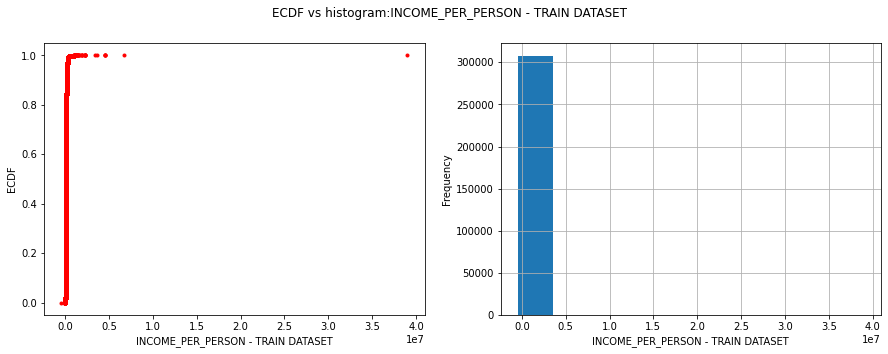

In [ ]:
#@title 5.1.1. INCOME_PER_PERSON
plot_feature(train_df.INCOME_PER_PERSON,label_ax="INCOME_PER_PERSON - TRAIN DATASET")

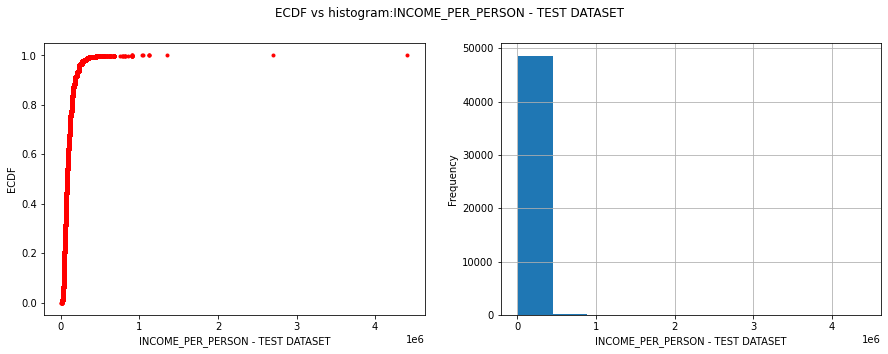

In [ ]:
plot_feature(test_df.INCOME_PER_PERSON,label_ax="INCOME_PER_PERSON - TEST DATASET")

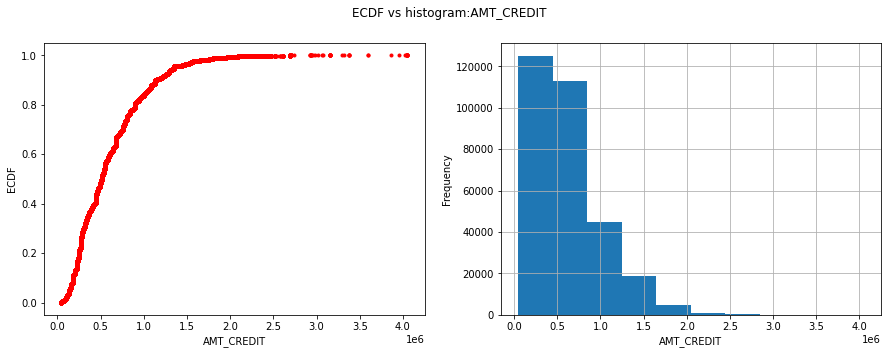

In [ ]:
#@title **5.1.2. AMT_CREDIT**
plot_feature(train_df.AMT_CREDIT,label_ax="AMT_CREDIT")

Actually we can see the shape of the plotted feature follows a Power-Log Distribution (stated differetly : long tail). </br>
It's a great pratice to attach it with a Log-Transformation, which let us to get it into a transformed Gaussian distribution. 

In [ ]:
train_df.AMT_CREDIT.describe().T

count    3.075110e+05
mean     5.988308e+05
std      4.024795e+05
min      4.500000e+04
25%      2.700000e+05
50%      5.135310e+05
75%      8.086500e+05
max      4.050000e+06
Name: AMT_CREDIT, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df.AMT_CREDIT = scaler.fit_transform(train_df.loc[:,['AMT_CREDIT']])
test_df.AMT_CREDIT = scaler.transform(test_df.loc[:,['AMT_CREDIT']])

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
log_scaled_feature, log_trasformer = log_transformation(train_df.AMT_CREDIT)
train_df['LOG_AMT_CREDIT'] = log_scaled_feature
test_df['LOG_AMT_CREDIT'] = log_trasformer.transform(test_df.loc[:,['AMT_CREDIT']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


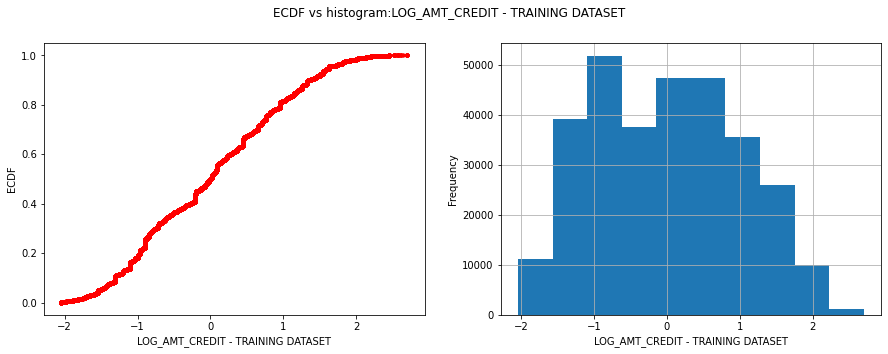

In [ ]:
plot_feature(train_df.LOG_AMT_CREDIT,label_ax="LOG_AMT_CREDIT - TRAINING DATASET")

Given the Gaussian distribution, we applied some feature engineering techniques in order to throw out the outliers.</br>
The outiliers increase the noise for our models as we known.

In [ ]:
ninthynine_ci= np.nanpercentile(train_df.LOG_AMT_CREDIT,[0.5,99.5])
mean = np.mean(train_df.LOG_AMT_CREDIT)
lower = ninthynine_ci[0]
upper = ninthynine_ci[1]

In [ ]:
upper_cutted = len(train_df[(train_df.LOG_AMT_CREDIT > upper)==True])
lower_cutted = len(train_df[(train_df.LOG_AMT_CREDIT  < lower )==True])
print("Number of samples changed, cut_off_lower {:d}, cut_of_upper {:d}".format(lower_cutted, upper_cutted))

Number of samples changed, cut_off_lower 1533, cut_of_upper 1537


In [ ]:
train_df.loc[(train_df['LOG_AMT_CREDIT'] < upper),'LOG_AMT_CREDIT'] = upper
train_df.loc[(train_df['LOG_AMT_CREDIT'] > lower),'LOG_AMT_CREDIT'] = lower

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


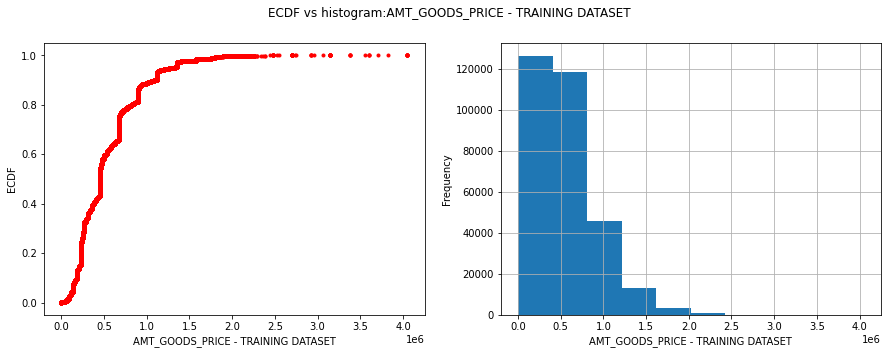

In [ ]:
  #@title **5.1.3. AMT_GOODS_PRICE**
plot_feature(train_df.AMT_GOODS_PRICE,label_ax="AMT_GOODS_PRICE - TRAINING DATASET")

Actually we can see the shape of the plotted feature follows a Power-Log Distribution (stated differetly : long tail). </br>
It's a great pratice to attach it with a Log-Transformation, which let us to get it into a transformed Gaussian distribution. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df.AMT_GOODS_PRICE = scaler.fit_transform(train_df.loc[:,['AMT_GOODS_PRICE']])
test_df.AMT_GOODS_PRICE = scaler.transform(test_df.loc[:,['AMT_GOODS_PRICE']])

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
log_scaled_feature, log_trasformer = log_transformation(train_df.AMT_GOODS_PRICE)
train_df['LOG_AMT_GOODS_PRICE'] = log_scaled_feature
test_df['LOG_AMT_GOODS_PRICE'] = log_trasformer.transform(test_df.loc[:,['AMT_GOODS_PRICE']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


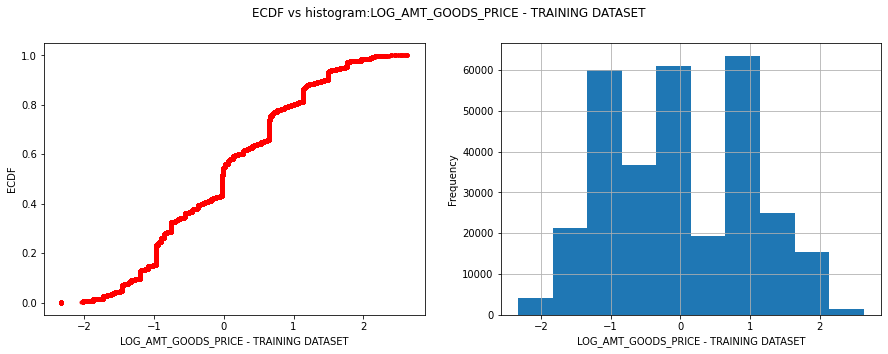

In [ ]:
plot_feature(train_df.LOG_AMT_GOODS_PRICE,label_ax="LOG_AMT_GOODS_PRICE - TRAINING DATASET")

Given the Gaussian distribution, we applied some feature engineering techniques in order to throw out the outliers.</br>
The outiliers increase the noise for our models as we known.

In [ ]:
ninthynine_ci= np.nanpercentile(train_df.LOG_AMT_GOODS_PRICE,[0.5,99.5])
mean = np.mean(train_df.LOG_AMT_GOODS_PRICE)
lower = ninthynine_ci[0]
upper = ninthynine_ci[1]

In [ ]:
upper_cutted = len(train_df[(train_df.LOG_AMT_GOODS_PRICE > upper)==True])
lower_cutted = len(train_df[(train_df.LOG_AMT_GOODS_PRICE  < lower )==True])
print("Number of samples changed, cut_off_lower {:d}, cut_of_upper {:d}".format(lower_cutted, upper_cutted))

Number of samples changed, cut_off_lower 1448, cut_of_upper 1431


In [ ]:
train_df.loc[(train_df['LOG_AMT_GOODS_PRICE'] < upper),'LOG_AMT_GOODS_PRICE'] = upper
train_df.loc[(train_df['LOG_AMT_GOODS_PRICE'] > lower),'LOG_AMT_GOODS_PRICE'] = lower

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#@title 5.2. Select features according to Pearson Correllation
def drop_corr_feature(X, threshold):
    col_corr = set()  # Set of all the names of deleted columns
    corr_matrix = X.corr()
    dropped_columns = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
                if colname in X.columns:
                    dropped_columns += [colname]
    return dropped_columns

In [ ]:
correlated_feature = drop_corr_feature(train_df, threshold=0.98)

In [ ]:
correlated_feature.remove("SK_ID_CURR")

In [ ]:
train_df.drop(columns=correlated_feature,inplace=True)

In [ ]:
test_df.drop(columns=correlated_feature,inplace=True)

# **6. Machine Learning Models**

In [ ]:
def k_fold_lgbm(df_train, df_test, folds = 10):
  import pickle
  from sklearn.model_selection import StratifiedKFold
  from lightgbm import LGBMClassifier
  
  lgb = None

  folds = StratifiedKFold(n_splits= folds, shuffle=True, random_state=SEED)
  sub_preds = np.zeros(df_test.shape[0])
  feats = [f for f in df_train.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
  

  for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df_train[feats], df_train['TARGET'])):
      train_x, train_y = df_train[feats].iloc[train_idx], df_train['TARGET'].iloc[train_idx]
      valid_x, valid_y = df_train[feats].iloc[valid_idx], df_train['TARGET'].iloc[valid_idx]

      lgb = LGBMClassifier(nthread=4, n_estimators=15000, learning_rate=0.02, num_leaves=31,
          colsample_bytree=0.85,subsample=0.9, max_depth=8, reg_alpha=0.0420, reg_lambda=0.073,random_state = SEED,
          min_split_gain=0.022, min_child_weight=39.32, silent=-1, tree_method='gpu_hist',verbose=300)

      lgb.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
          eval_metric= 'auc', verbose= 200, early_stopping_rounds= 100)

      sub_preds += lgb.predict_proba(df_test[feats], num_iteration=lgb.best_iteration_)[:, 1] / folds.n_splits

      del train_x, train_y, valid_x, valid_y
      gc.collect()

  df_test['TARGET'] = sub_preds
  return df_test

In [ ]:
test_df = k_fold_lgbm(df_train = train_df, df_test = test_df, folds = 10)

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.791078	training's binary_logloss: 0.237789	valid_1's auc: 0.76879	valid_1's binary_logloss: 0.243281
[400]	training's auc: 0.811465	training's binary_logloss: 0.229215	valid_1's auc: 0.778311	valid_1's binary_logloss: 0.239472
[600]	training's auc: 0.825121	training's binary_logloss: 0.223761	valid_1's auc: 0.782677	valid_1's binary_logloss: 0.23803
[800]	training's auc: 0.836048	training's binary_logloss: 0.219435	valid_1's auc: 0.784406	valid_1's binary_logloss: 0.237452
[1000]	training's auc: 0.845531	training's binary_logloss: 0.215658	valid_1's auc: 0.785662	valid_1's binary_logloss: 0.237103
[1200]	training's auc: 0.854203	training's binary_logloss: 0.212098	valid_1's auc: 0.786083	valid_1's binary_logloss: 0.23697
Early stopping, best iteration is:
[1236]	training's auc: 0.855648	training's binary_logloss: 0.211487	valid_1's auc: 0.786275	valid_1's binary_logloss: 0.236907
Training until valid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
test_df.loc[:,['SK_ID_CURR']] = application_test.loc[:,['SK_ID_CURR']]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [ ]:
import pickle
imp_pickle_filename = PATH_PICKLE+"/xgb_model.pkl"
with open(imp_pickle_filename, "rb") as imp_pickle:
  lgbm = pickle.load(imp_pickle)

In [ ]:
result = list(zip(list(X_train.columns),list(lgbm.feature_importances_)))
result.sort(key=lambda x: x[1], reverse=True) 
result = result[:10]

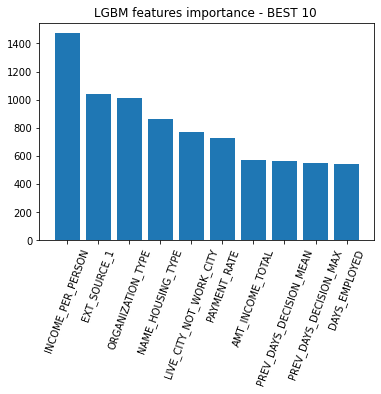

In [ ]:
import matplotlib.pyplot as plt
plt.title("LGBM features importance - BEST 10 ")
plt.bar(range(len(result)), [val[1] for val in result], align='center')
plt.xticks(range(len(result)), [val[0] for val in result])
plt.xticks(rotation=70)
plt.show()